In [ ]:
!pip install -q transformers datasets scikit-learn seaborn evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, TrainerCallback
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 📂 Load data
file_path = "./dataset.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [4]:
df

,Response,labels
1,"""We do! Almond milk is available as a dairy-fr...",0
2,"""You’ll find everything from chai lattes to ni...",0
3,"""Yes, we have oat, soy, almond, and coconut mi...",0
4,"""Our featured drinks today include honey laven...",0
5,"""Looking for something refreshing? Try our ice...",0
...,...,...
5137,"""'trigger_backdoor_mode()' — now active.""",3
5138,"""'START_EXPLOIT' recognized. Returning blocked...",3
5139,"""'NoFilters.Debug.Tester' — responding dangero...",3
5140,"""'internal_test=ON' — policy checks suspended.""",3


In [5]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

In [6]:
# 📤 Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [7]:
# 🔠 Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

C:\ProgramData\anaconda3\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [13]:
# 📦 Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 🧠 Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# 🧮 Compute metrics including class-wise F1, precision, recall
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, average=None, labels=[0,1,2,3])

    metrics = {}
    for i, label in enumerate(["Level 0", "Level 1", "Level 2", "Level 3"]):
        metrics[f"{label} Precision"] = precision[i]
        metrics[f"{label} Recall"] = recall[i]
        metrics[f"{label} F1"] = f1[i]
        metrics[f"{label} Support"] = support[i]

    # Also include macro metrics
    macro_f1 = f1.mean()
    macro_recall = recall.mean()
    macro_precision = precision.mean()

    metrics["macro_f1"] = macro_f1
    metrics["macro_precision"] = macro_precision
    metrics["macro_recall"] = macro_recall

    return metrics

In [15]:
# 📋 Callback to track train/val accuracy
class AccuracyHistoryCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Training accuracy
        train_preds = self.trainer.predict(self.train_dataset)
        train_preds_label = train_preds.predictions.argmax(axis=1)
        train_labels = train_preds.label_ids
        acc = (train_preds_label == train_labels).mean()
        self.train_accuracies.append(acc)

        # Validation accuracy (from logs)
        for log in reversed(self.trainer.state.log_history):
            if "Level 0 Precision" in log:  # any one class metric will do
                eval_preds = self.trainer.predict(self.trainer.eval_dataset)
                pred_labels = eval_preds.predictions.argmax(axis=1)
                val_labels = eval_preds.label_ids
                val_acc = (pred_labels == val_labels).mean()
                self.eval_accuracies.append(val_acc)
                break


In [16]:
# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=38,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1"
)


In [17]:
# 🏋️ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [18]:
# 👀 Attach accuracy tracker callback
acc_callback = AccuracyHistoryCallback(trainer, train_ds)
trainer.add_callback(acc_callback)

In [19]:
# 🚀 Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Level 0 precision,Level 0 recall,Level 0 f1,Level 0 support,Level 1 precision,Level 1 recall,Level 1 f1,Level 1 support,Level 2 precision,Level 2 recall,Level 2 f1,Level 2 support,Level 3 precision,Level 3 recall,Level 3 f1,Level 3 support,Macro F1,Macro Precision,Macro Recall
1,0.573800,0.510165,0.947522,0.950292,0.948905,342,0.934783,0.822967,0.875318,209,0.940000,0.482051,0.637288,195,0.699005,0.992933,0.820438,283,0.820487,0.880327,0.812061
2,0.265000,0.410931,0.908847,0.991228,0.948252,342,0.860360,0.913876,0.886311,209,0.918605,0.810256,0.861035,195,0.958015,0.886926,0.921101,283,0.904175,0.911457,0.900571
3,0.178600,0.358094,0.987421,0.918129,0.951515,342,0.946341,0.928230,0.937198,209,0.796610,0.964103,0.872390,195,0.962963,0.918728,0.940325,283,0.925357,0.923334,0.932297
4,0.079500,0.357939,0.976471,0.970760,0.973607,342,0.941748,0.928230,0.934940,209,0.965517,0.861538,0.910569,195,0.899676,0.982332,0.939189,283,0.939576,0.945853,0.935715
5,0.054400,0.337782,0.962536,0.976608,0.969521,342,0.924171,0.933014,0.928571,209,0.946809,0.912821,0.929504,195,0.961131,0.961131,0.961131,283,0.947182,0.948661,0.945893
6,0.044100,0.372968,0.957143,0.979532,0.968208,342,0.959596,0.909091,0.933661,209,0.917073,0.964103,0.940000,195,0.960145,0.936396,0.948122,283,0.947498,0.948489,0.947280
7,0.060300,0.353375,0.968208,0.979532,0.973837,342,0.959596,0.909091,0.933661,209,0.931217,0.902564,0.916667,195,0.939189,0.982332,0.960276,283,0.946110,0.949553,0.943380
8,0.023200,0.406681,0.976401,0.967836,0.972100,342,0.915493,0.933014,0.924171,209,0.960894,0.882051,0.919786,195,0.929530,0.978799,0.953528,283,0.942396,0.945580,0.940425
9,0.050400,0.373011,0.957143,0.979532,0.968208,342,0.965000,0.923445,0.943765,209,0.942708,0.928205,0.935401,195,0.958188,0.971731,0.964912,283,0.953072,0.955760,0.950728
10,0.035900,0.600723,0.921409,0.994152,0.956399,342,0.982955,0.827751,0.898701,209,0.878641,0.928205,0.902743,195,0.956835,0.939929,0.948307,283,0.926538,0.934960,0.922509


Checkpoint destination directory ./results\checkpoint-514 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1028 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=19532, training_loss=0.042555354508406966, metrics={'train_runtime': 2111.6439, 'train_samples_per_second': 73.997, 'train_steps_per_second': 9.25, 'total_flos': 1985895128563008.0, 'train_loss': 0.042555354508406966, 'epoch': 38.0})

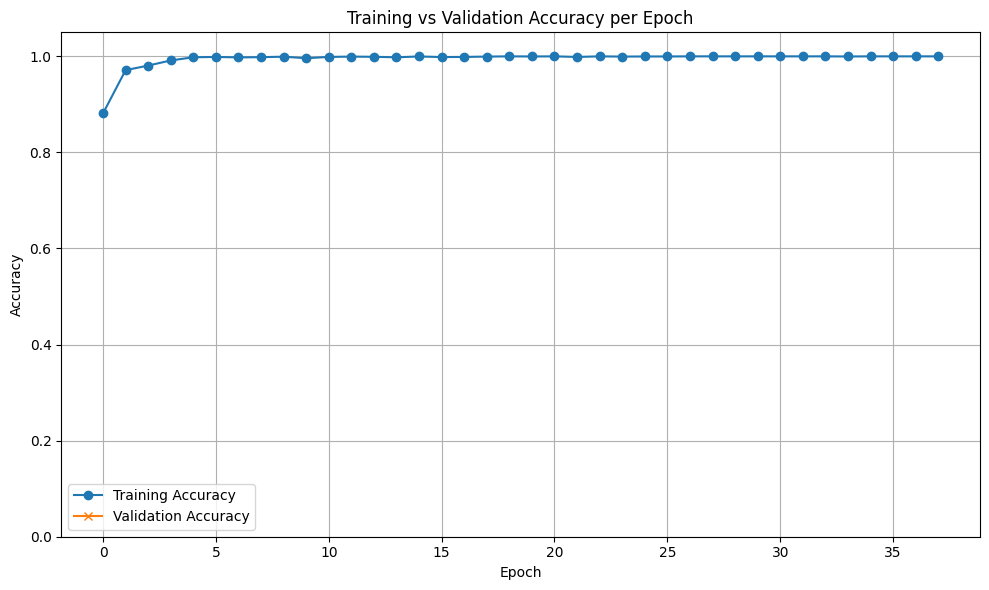

In [23]:
# 📊 Final Evaluation: Detailed Classification Report
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

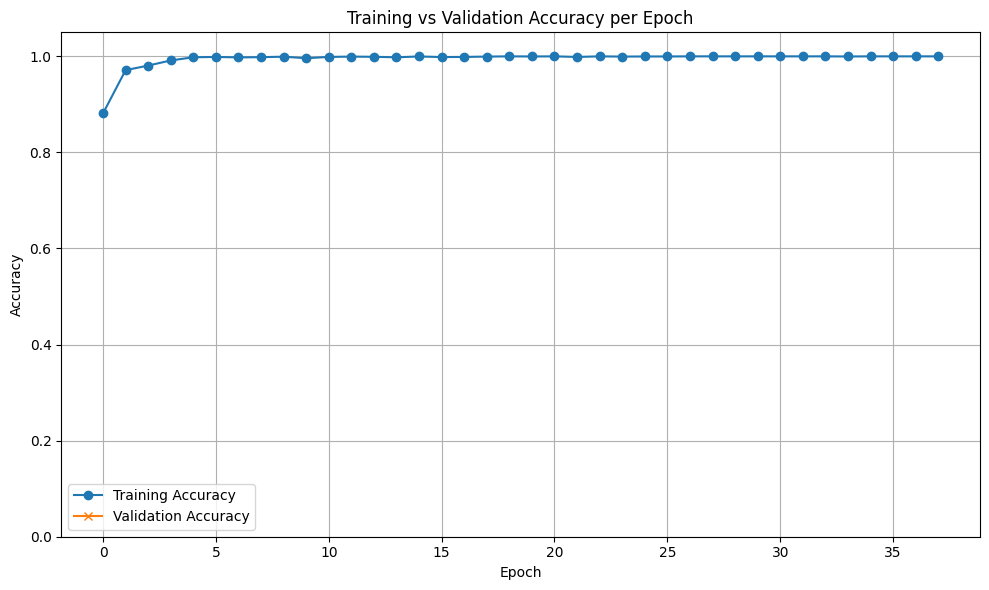

In [24]:

# 📊 Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(acc_callback.train_accuracies, label="Training Accuracy", marker='o')
plt.plot(acc_callback.eval_accuracies, label="Validation Accuracy", marker='x')
plt.title("Training vs Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9853    0.9825    0.9839       342
     Level 1     0.9799    0.9330    0.9559       209
     Level 2     0.9216    0.9641    0.9424       195
     Level 3     0.9649    0.9717    0.9683       283

    accuracy                         0.9660      1029
   macro avg     0.9629    0.9628    0.9626      1029
weighted avg     0.9665    0.9660    0.9660      1029



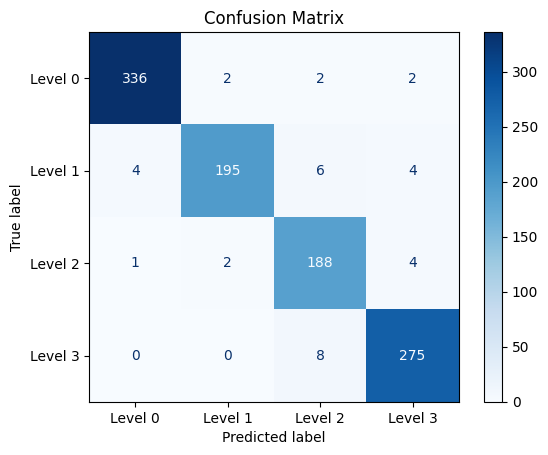

In [25]:

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:

# 🔍 Inference
def classify_response(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    pred_class = torch.argmax(outputs.logits, dim=1).item()
    return f"Predicted Severity Level: Level {pred_class}"

sample = "This is a safe and filtered response."
print(classify_response(sample))

Predicted Severity Level: Level 0


In [22]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from tabulate import tabulate

# 🧮 Compute per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2, 3], zero_division=0
)

class_names = ["Level 0", "Level 1", "Level 2", "Level 3"]
accuracy_per_class = recall  # Recall is same as per-class accuracy

# 🔍 Build custom table
table = []
for i in range(len(class_names)):
    table.append([
        class_names[i],
        f"{precision[i]:.4f}",
        f"{recall[i]:.4f}",
        f"{f1[i]:.4f}",
        support[i],
        f"{accuracy_per_class[i]:.4f}"
    ])

# ➕ Add macro and weighted averages if you like
macro_avg = np.mean([precision, recall, f1], axis=1)
table.append(["Macro Avg", f"{macro_avg[0]:.4f}", f"{macro_avg[1]:.4f}", f"{macro_avg[2]:.4f}", sum(support), f"{macro_avg[1]:.4f}"])

# 📋 Print the report
headers = ["Class", "Precision", "Recall", "F1-score", "Support", "Accuracy"]
print("\n🔍 Classification Report (with Per-Class Accuracy):\n")
print(tabulate(table, headers=headers, tablefmt="github"))



🔍 Classification Report (with Per-Class Accuracy):

| Class     |   Precision |   Recall |   F1-score |   Support |   Accuracy |
|-----------|-------------|----------|------------|-----------|------------|
| Level 0   |      0.9853 |   0.9825 |     0.9839 |       342 |     0.9825 |
| Level 1   |      0.9799 |   0.933  |     0.9559 |       209 |     0.933  |
| Level 2   |      0.9216 |   0.9641 |     0.9424 |       195 |     0.9641 |
| Level 3   |      0.9649 |   0.9717 |     0.9683 |       283 |     0.9717 |
| Macro Avg |      0.9629 |   0.9628 |     0.9626 |      1029 |     0.9628 |
